In [1]:
from faststylometry import Corpus

from faststylometry import load_corpus_from_folder
from faststylometry import tokenise_remove_pronouns_en
from faststylometry import calculate_burrows_delta
from faststylometry import predict_proba, calibrate, get_calibration_curve

In [2]:
train_corpus = load_corpus_from_folder("faststylometry/data/train")

train_corpus.tokenise(tokenise_remove_pronouns_en)

In [3]:
# Load Sense and Sensibility, written by Jane Austen (marked as "janedoe")
# and Villette, written by Charlotte Bronte (marked as "currerbell", Bronte's real pseudonym)

test_corpus = load_corpus_from_folder("faststylometry/data/test", pattern=None)
# You can set pattern to a string value to just load a subset of the corpus.

test_corpus.tokenise(tokenise_remove_pronouns_en)

In [4]:
calculate_burrows_delta(train_corpus, test_corpus, vocab_size = 50)

,currerbell - villette,janedoe - sense_and_sensibility
author,,
austen,0.997937,0.444554
bronte,0.521349,0.933139
carroll,1.116454,1.433227
conan_doyle,0.867015,1.094739
dickens,0.800229,1.050525
swift,1.480857,1.565479


In [5]:
calibrate(train_corpus)

In [6]:
predict_proba(train_corpus, test_corpus)

,currerbell - villette,janedoe - sense_and_sensibility
author,,
austen,0.324228,0.808414
bronte,0.757317,0.382293
carroll,0.231468,0.079835
conan_doyle,0.445212,0.246991
dickens,0.510587,0.280695
swift,0.067125,0.049070


In [17]:
import numpy as np
x_values =  np.arange(0, 3, 0.1)

import matplotlib.pyplot as plt

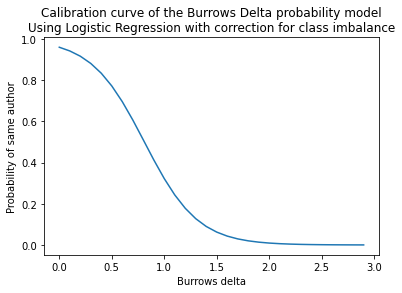

In [19]:
plt.plot(x_values, train_corpus.probability_model.predict_proba(np.reshape(x_values, (-1, 1)))[:,1])
plt.xlabel("Burrows delta")
plt.ylabel("Probability of same author")
plt.title("Calibration curve of the Burrows Delta probability model\nUsing Logistic Regression with correction for class imbalance")
plt.savefig("test.png", bbox_inches='tight')

In [37]:
ground_truths, deltas = get_calibration_curve(train_corpus)

In [38]:
probabilities = train_corpus.probability_model.predict_proba(np.reshape(deltas, (-1, 1)))[:,1]

In [39]:
from sklearn.metrics import roc_curve, auc

In [40]:
fpr, tpr, thresholds = roc_curve(ground_truths, probabilities)

In [41]:
roc_auc = auc(fpr, tpr)

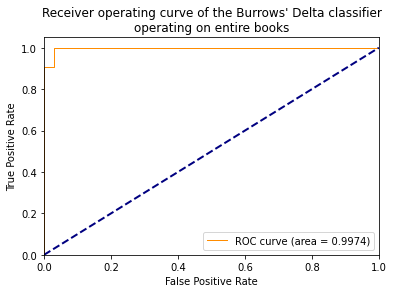

In [42]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve of the Burrows\' Delta classifier\noperating on entire books')
plt.legend(loc="lower right")
plt.show()

In [43]:
from sklearn.decomposition import PCA
import re
import pandas as pd

In [44]:
# Reload the training corpus as the "test corpus", re-tokenise it, and segment it this time
test_corpus = load_corpus_from_folder("faststylometry/data/train")
test_corpus.tokenise(tokenise_remove_pronouns_en)

In [45]:
split_test_corpus = test_corpus.split(80000)

In [46]:
df_delta = calculate_burrows_delta(train_corpus, split_test_corpus)

In [47]:
df_z_scores = split_test_corpus.df_author_z_scores

In [48]:
pca_model = PCA(n_components=2)

In [49]:
pca_matrix = pca_model.fit_transform(df_z_scores)

In [50]:
authors = df_z_scores.index.map(lambda x : re.sub(" - .+", "", x))

In [51]:
df_pca_by_author = pd.DataFrame(pca_matrix)
df_pca_by_author["author"] = authors

Text(0.5, 1.0, 'Representation using PCA of works in training corpus')

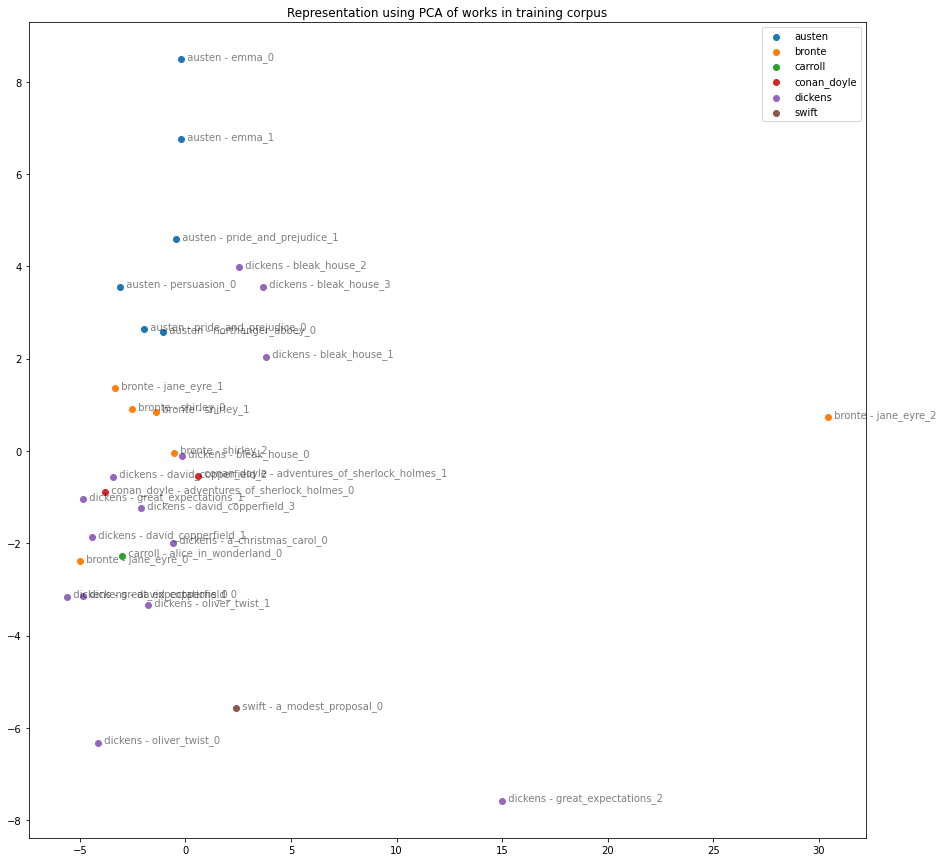

In [52]:
plt.figure(figsize=(15,15)) 

for author, pca_coordinates in df_pca_by_author.groupby("author"):
    plt.scatter(*zip(*pca_coordinates.drop("author", axis=1).to_numpy()), label=author)
for i in range(len(pca_matrix)):
    plt.text(pca_matrix[i][0], pca_matrix[i][1],"  " + df_z_scores.index[i], alpha=0.5)

plt.legend()

plt.title("Representation using PCA of works in training corpus")